In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from itertools import groupby
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2.2.2


In [11]:
dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/Residence_Time_Prediction/aro_contacts.npy")
print(np.mean(dfaro, axis=0))
dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/aro_contacts.npy")
print(np.mean(dfaro, axis=0))

[0.08512282 0.09147539 0.10615642]
[0.14033749 0.19075856 0.17453167]


In [12]:
dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/Residence_Time_Prediction/charge_dist_matrix.npy")
print(np.mean(dfaro, axis=0))
dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/charge_dist_matrix.npy")
print(np.mean(dfaro, axis=0))

[1.9507102 1.884313  1.7997782 1.7767532 1.7650836 1.6488566 1.686521
 1.7584385 1.8052192]
[1.9396567 1.8702015 1.7454205 1.7111697 1.7059233 1.5993794 1.7016528
 1.7842461 1.862518 ]


In [6]:
df = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/lig47_hbonds_dict")

frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/aro_contacts.npy")

dcharges = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/charge_dist_matrix.npy")
print(dcharges.shape)

hydrodf = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/hphob_dict_lig47")

frames = [hydrodf[key]['distance'] for key in hydrodf.keys()]
hydrocombined = np.concatenate(frames, axis=1)
print(hydrocombined.shape)

dmat = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/distance_matrix_full_LIG.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]


(1100889, 314)
(1100889, 9)
(1100889, 1500)
(1100889, 20)


In [ ]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2, whiten=True)

pca1.fit(combined)
hbond_pca = pca1.transform(combined)

pca2 = PCA(n_components=2, whiten=True)

pca2.fit(dcharges)
charges_pca = pca2.transform(dcharges)

pca3 = PCA(n_components=2, whiten=True)

pca3.fit(hydrocombined)
hydro_pca = pca3.transform(hydrocombined)

pca4 = PCA(n_components=2, whiten=True)

pca4.fit(dfaro)
aro_pca = pca4.transform(dfaro)





In [13]:
print(hbond_pca.shape)
print(aro_pca.shape)
print(charges_pca.shape)
print(hydro_pca.shape)

(1100889, 2)
(1100889, 2)
(1100889, 2)
(1100889, 2)


In [36]:
N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), len(hbond_pca[0,:])])
avg_aro_all = np.zeros([len(events_all), len(aro_pca[0,:])])
avg_charges_all = np.zeros([len(events_all), len(charges_pca[0,:])])
avg_hydro_all = np.zeros([len(events_all), len(hydro_pca[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.mean(hbond_pca[event[0]:event[-1]+1], axis=0)
  avg_aro_all[count] = np.mean(aro_pca[event[0]:event[-1]+1], axis=0)
  avg_charges_all[count] = np.mean(charges_pca[event[0]:event[-1]+1], axis=0)
  avg_hydro_all[count] = np.mean(hydro_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  
avg_new = np.concatenate([avg_all,avg_hbond_all, avg_aro_all, avg_hydro_all, avg_charges_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)


7895
[   0    1    2 ... 7892 7893 7894]
1128
[7895 7896 7897 ... 9020 9021 9022]
2256
[ 9023  9024  9025 ... 11276 11277 11278]
Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 28)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 28)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 28)


In [37]:
mapping = mapping_5_476
avg = avg_5_476

print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))


max length: 476.0
min length: 5.0
max log length: 4.76
min log length: 0.05
mean: [ 1.42916224  1.37011894  1.31571755  1.35058167  1.227108    1.24078511
  1.2223932   1.24681741  1.24418795  1.21032906  1.20343746  1.25658049
  1.1358778   1.14637195  1.17298661  1.11424589  1.15071183  1.22499229
  1.20205116  1.30301088  0.15247353  0.23456484 -0.3551325  -0.1631726
  0.31782326  0.15062231  0.14700535  0.29257894]
std deviation: [0.48050119 0.49377814 0.52716466 0.51856525 0.50365845 0.50344977
 0.47637328 0.46924951 0.46724376 0.49043033 0.49153119 0.46918486
 0.45909269 0.45092947 0.47246284 0.47498547 0.50627984 0.51832394
 0.54566229 0.55149194 0.86267953 0.78328347 0.46558728 0.48383401
 0.73617731 0.90594422 0.80300663 0.68331686]
standardized avg distance data
(7895, 28)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21768 | val_0_mse: 0.6093  |  0:00:00s
epoch 1  | loss: 0.56814 | val_0_mse: 0.46594 |  0:00:00s
epoch 2  | loss: 0.50492 | val_0_mse: 0.43879 |  0:00:01s
epoch 3  | loss: 0.47915 | val_0_mse: 0.45073 |  0:00:01s
epoch 4  | loss: 0.44934 | val_0_mse: 0.42933 |  0:00:01s
epoch 5  | loss: 0.44362 | val_0_mse: 0.38775 |  0:00:02s
epoch 6  | loss: 0.43216 | val_0_mse: 0.43588 |  0:00:02s
epoch 7  | loss: 0.4098  | val_0_mse: 0.39069 |  0:00:02s
epoch 8  | loss: 0.39636 | val_0_mse: 0.39152 |  0:00:03s
epoch 9  | loss: 0.40175 | val_0_mse: 0.37313 |  0:00:03s
epoch 10 | loss: 0.39676 | val_0_mse: 0.35112 |  0:00:03s
epoch 11 | loss: 0.38551 | val_0_mse: 0.33543 |  0:00:04s
epoch 12 | loss: 0.38979 | val_0_mse: 0.34922 |  0:00:04s
epoch 13 | loss: 0.3803  | val_0_mse: 0.34732 |  0:00:04s
epoch 14 | loss: 0.36774 | val_0_mse: 0.34061 |  0:00:05s
epoch 15 | loss: 0.38134 | val_0_mse: 0.34624 |  0:00:05s
epoch 16 | loss: 0.36601 | val_0_mse: 0.33223 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1.9964966  0.15116923 0.20024654 ... 0.1478898  0.16220494 1.620498  ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
48.376884
52.27925531914894


In [38]:
top = (-al2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
top = (-ap2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
bottom = (ap2).argsort(axis=0)[:10]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted 241.16185 real: 475.0
predicted 221.17152 real: 471.0
predicted 227.71674 real: 467.0
predicted 223.53894 real: 467.0
predicted 153.7909 real: 461.00000000000006
predicted 243.54535 real: 461.00000000000006
predicted 209.8421 real: 454.0
predicted 164.053 real: 454.0
predicted 294.40073 real: 448.00000000000006
predicted 191.24924 real: 443.0

predicted 314.3151 real: 419.00000000000006
predicted 308.0764 real: 313.0
predicted 307.55905 real: 390.0
predicted 303.6637 real: 417.0
predicted 303.184 real: 274.0
predicted 294.40073 real: 448.00000000000006
predicted 292.83862 real: 259.0
predicted 291.6341 real: 336.0
predicted 286.7649 real: 216.0
predicted 281.73996 real: 102.0

predicted -13.534487 real: 6.0
predicted -9.626818 real: 21.0
predicted -7.8397603 real: 6.0
predicted -6.0664415 real: 7.000000000000001
predicted -4.3610454 real: 9.0
predicted -3.2475858 real: 47.0
predicted -2.4602652 real: 38.0
predicted -1.276295 real: 5.0
predicted -0.057059526 real: 20.0
predict

r2: 0.7612115158571622


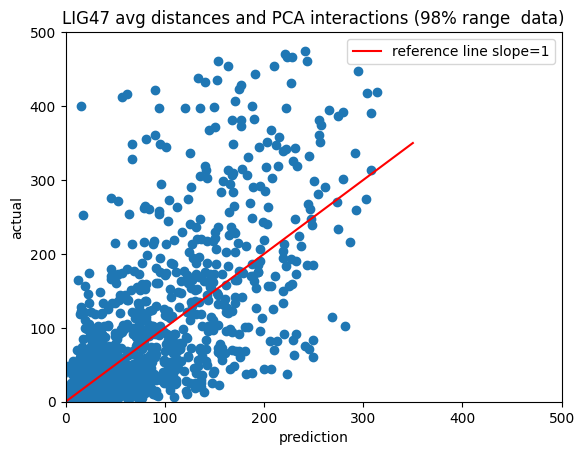

In [39]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 avg distances and PCA interactions (98% range  data)")
plt.ylabel('actual')
plt.xlim([0,500])
plt.ylim([0,500])
plt.legend()
plt.xlabel('prediction')
plt.show()


In [40]:
# inputs = torch.from_numpy(std_avg)
# inputs = torch.tensor(inputs, dtype=torch.float32)
# print(inputs.shape)
# print(inputs)
# targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
# targets = torch.tensor(targets, dtype=torch.float32)
# print(targets.shape)
# print(targets)
# dataset = TensorDataset(inputs, targets)

# N = dmat.shape[0]
N = len(events_all)
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), len(hbond_pca[0,:])])
avg_aro_all = np.zeros([len(events_all), len(aro_pca[0,:])])
avg_charges_all = np.zeros([len(events_all), len(charges_pca[0,:])])
avg_hydro_all = np.zeros([len(events_all), len(hydro_pca[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.mean(hbond_pca[event[0]:event[-1]+1], axis=0)
  avg_aro_all[count] = np.mean(aro_pca[event[0]:event[-1]+1], axis=0)
  avg_charges_all[count] = np.mean(charges_pca[event[0]:event[-1]+1], axis=0)
  avg_hydro_all[count] = np.mean(hydro_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  
avg_new = np.concatenate([avg_all,avg_hbond_all, avg_aro_all, avg_hydro_all, avg_charges_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_all
avg = avg_new

print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

22584
[    0     1     2 ... 22581 22582 22583]
3227
[22584 22585 22586 ... 25808 25809 25810]
6453
[25811 25812 25813 ... 32261 32262 32263]
Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 28)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 28)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 28)
max length: 12021.0
min length: 1.0
max log length: 120.21
min log length: 0.01
mean: [ 1.45652661  1.42421257  1.38172276  1.44046781  1.33266462  1.35720402
  1.35195526  1.38690613  1.38588823  1.33485526  1.32987891  1.4034782
  1.28932623  1.30673398  1.32943799  1.26828554  1.2911307   1.35255405
  1.30806721  1.3861965   0.32925131  0.5211485  -0.45163991 -0.22581814
  0.61316417  0.27173304  0.28116561  0.50265792]
std deviation: [0.5443374  0.53097404 0.55025525 0.52478114 0.50648978 0.51083706
 0.49258866 0.49523559 0.50256003 0.53488036 

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26047 | val_0_mse: 1.15861 |  0:00:01s
epoch 1  | loss: 1.71873 | val_0_mse: 0.83299 |  0:00:02s
epoch 2  | loss: 1.69207 | val_0_mse: 0.82265 |  0:00:03s
epoch 3  | loss: 1.67632 | val_0_mse: 0.77987 |  0:00:04s
epoch 4  | loss: 1.64116 | val_0_mse: 0.82482 |  0:00:05s
epoch 5  | loss: 1.62654 | val_0_mse: 0.8244  |  0:00:06s
epoch 6  | loss: 1.62257 | val_0_mse: 0.92453 |  0:00:07s
epoch 7  | loss: 1.60699 | val_0_mse: 0.78356 |  0:00:08s
epoch 8  | loss: 1.56683 | val_0_mse: 0.71832 |  0:00:09s
epoch 9  | loss: 1.55645 | val_0_mse: 0.75238 |  0:00:11s
epoch 10 | loss: 1.51536 | val_0_mse: 0.80161 |  0:00:12s
epoch 11 | loss: 1.54987 | val_0_mse: 0.83628 |  0:00:13s
epoch 12 | loss: 1.55411 | val_0_mse: 0.7097  |  0:00:14s
epoch 13 | loss: 1.51485 | val_0_mse: 0.75595 |  0:00:16s
epoch 14 | loss: 1.51533 | val_0_mse: 0.81623 |  0:00:17s
epoch 15 | loss: 1.55783 | val_0_mse: 0.7367  |  0:00:18s
epoch 16 | loss: 1.54168 | val_0_mse: 0.68566 |  0:00:19s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0.00880368 0.0336595  0.05026734 ... 0.0193962  0.0193962  1.8682281 ]
[0.01 0.01 0.01 ... 0.17 0.01 1.58]
24.794071
27.773748644041532


r2: 0.6924919969076536


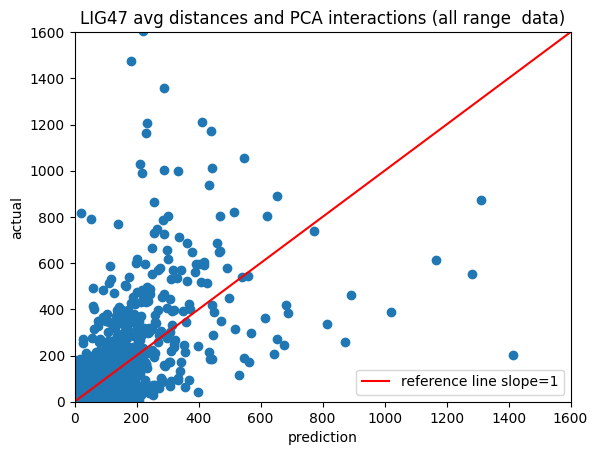

In [41]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 1600,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 avg distances and PCA interactions (all range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,1600])
plt.ylim([0,1600])
plt.show()

In [42]:
# inputs = torch.from_numpy(std_avg)
# inputs = torch.tensor(inputs, dtype=torch.float32)
# print(inputs.shape)
# print(inputs)
# targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
# targets = torch.tensor(targets, dtype=torch.float32)
# print(targets.shape)
# print(targets)
# dataset = TensorDataset(inputs, targets)

# N = dmat.shape[0]
N = len(mapping_25_476)
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), len(hbond_pca[0,:])])
avg_aro_all = np.zeros([len(events_all), len(aro_pca[0,:])])
avg_charges_all = np.zeros([len(events_all), len(charges_pca[0,:])])
avg_hydro_all = np.zeros([len(events_all), len(hydro_pca[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.mean(hbond_pca[event[0]:event[-1]+1], axis=0)
  avg_aro_all[count] = np.mean(aro_pca[event[0]:event[-1]+1], axis=0)
  avg_charges_all[count] = np.mean(charges_pca[event[0]:event[-1]+1], axis=0)
  avg_hydro_all[count] = np.mean(hydro_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  
avg_new = np.concatenate([avg_all,avg_hbond_all, avg_aro_all, avg_hydro_all, avg_charges_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_25_476
avg = avg_25_476

print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

3212
[   0    1    2 ... 3209 3210 3211]
459
[3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225
 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239
 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253
 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267
 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3280 3281
 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295
 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309
 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320 3321 3322 3323
 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 3335 3336 3337
 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351
 3352 3353 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365
 3366 3367 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379
 3380 3381 3382 3383 3384 3385 3386 3387 3388 3389 3390 3391 3392 3393
 3394 3395 3396 3397 3398 3399 3

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.09378 | val_0_mse: 1.31426 |  0:00:00s
epoch 1  | loss: 1.26651 | val_0_mse: 0.95916 |  0:00:00s
epoch 2  | loss: 1.02389 | val_0_mse: 0.87753 |  0:00:00s
epoch 3  | loss: 0.92801 | val_0_mse: 0.92091 |  0:00:00s
epoch 4  | loss: 0.87003 | val_0_mse: 0.85685 |  0:00:00s
epoch 5  | loss: 0.82569 | val_0_mse: 0.79823 |  0:00:01s
epoch 6  | loss: 0.83327 | val_0_mse: 0.82591 |  0:00:01s
epoch 7  | loss: 0.80543 | val_0_mse: 0.80016 |  0:00:01s
epoch 8  | loss: 0.78787 | val_0_mse: 0.77834 |  0:00:01s
epoch 9  | loss: 0.77247 | val_0_mse: 0.80659 |  0:00:01s
epoch 10 | loss: 0.75641 | val_0_mse: 0.76381 |  0:00:01s
epoch 11 | loss: 0.75735 | val_0_mse: 0.77977 |  0:00:01s
epoch 12 | loss: 0.72495 | val_0_mse: 0.76455 |  0:00:02s
epoch 13 | loss: 0.71796 | val_0_mse: 0.75171 |  0:00:02s
epoch 14 | loss: 0.71881 | val_0_mse: 0.73598 |  0:00:02s
epoch 15 | loss: 0.7084  | val_0_mse: 0.72749 |  0:00:02s
epoch 16 | loss: 0.71728 | val_0_mse: 0.73219 |  0:00:02s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


r2: 0.6563040530939991


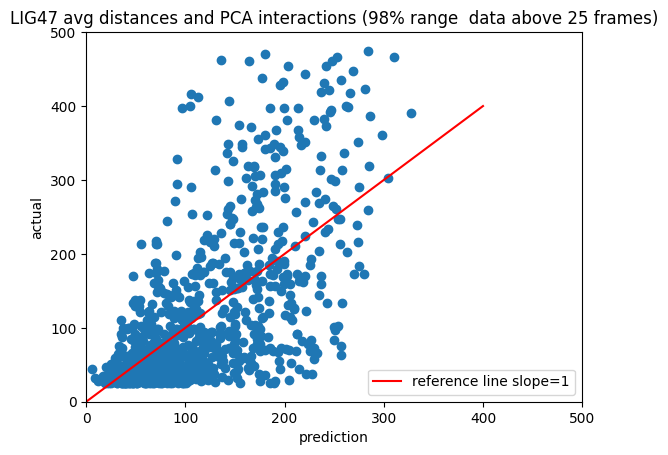

In [44]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 avg distances and PCA interactions (98% range  data above 25 frames)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [4]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=4, whiten=True)

pca1.fit(combined)
hbond_pca = pca1.transform(combined)

pca2 = PCA(n_components=4, whiten=True)

pca2.fit(dcharges)
charges_pca = pca2.transform(dcharges)

pca3 = PCA(n_components=4, whiten=True)

pca3.fit(hydrocombined)
hydro_pca = pca3.transform(hydrocombined)

all_input = np.concatenate([dmat, hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)


In [8]:
print(all_input.shape)

(1100889, 35)


In [27]:
pca_all30 = PCA(n_components=30, whiten=True)

pca_all30.fit(all_input)
inputs_pca30 = pca_all30.transform(all_input)

In [24]:
pca_all20 = PCA(n_components=20, whiten=True)

pca_all20.fit(all_input)
inputs_pca20 = pca_all20.transform(all_input)

In [9]:
pca_all12 = PCA(n_components=12, whiten=True)

pca_all12.fit(all_input)
inputs_pca12 = pca_all12.transform(all_input)


In [16]:
pca_all2 = PCA(n_components=2, whiten=True)

pca_all2.fit(all_input)
inputs_pca2 = pca_all2.transform(all_input)

In [21]:
inputs_pca = inputs_pca12

N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_all[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_5_476
avg = avg_5_476

logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

Total events: 32264
With avg distance input data of shape: (32264, 12)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 12)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 12)
max log length: 4.76
min log length: 0.05
mean: [ 0.34413808  0.03904242  0.00209437 -0.28257281  0.01678794  0.10377099
  0.05389266  0.16973945  0.08508231 -0.03675518  0.01203758  0.00473136]
std deviation: [0.65125155 0.96593141 0.96186977 0.80327378 0.82940277 0.83103442
 0.67334621 0.69835141 0.77443091 0.68792824 0.74000849 0.54743547]
standardized avg distance data
(7895, 12)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2814  | val_0_mse: 0.63238 |  0:00:00s
epoch 1  | loss: 0.6172  | val_0_mse: 0.49778 |  0:00:00s
epoch 2  | loss: 0.50995 | val_0_mse: 0.4435  |  0:00:01s
epoch 3  | loss: 0.46346 | val_0_mse: 0.42346 |  0:00:01s
epoch 4  | loss: 0.44065 | val_0_mse: 0.42526 |  0:00:01s
epoch 5  | loss: 0.42668 | val_0_mse: 0.40239 |  0:00:02s
epoch 6  | loss: 0.42259 | val_0_mse: 0.37126 |  0:00:02s
epoch 7  | loss: 0.40829 | val_0_mse: 0.36257 |  0:00:02s
epoch 8  | loss: 0.39777 | val_0_mse: 0.35754 |  0:00:02s
epoch 9  | loss: 0.39518 | val_0_mse: 0.35024 |  0:00:03s
epoch 10 | loss: 0.38454 | val_0_mse: 0.36003 |  0:00:03s
epoch 11 | loss: 0.38434 | val_0_mse: 0.35991 |  0:00:03s
epoch 12 | loss: 0.37465 | val_0_mse: 0.35048 |  0:00:04s
epoch 13 | loss: 0.36987 | val_0_mse: 0.33327 |  0:00:04s
epoch 14 | loss: 0.35264 | val_0_mse: 0.35898 |  0:00:04s
epoch 15 | loss: 0.35468 | val_0_mse: 0.34917 |  0:00:05s
epoch 16 | loss: 0.354   | val_0_mse: 0.33493 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [22]:
print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[2.0364373  0.29606336 0.16891192 ... 0.13623326 0.2667347  1.8286984 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
49.9101
52.27925531914894


r2: 0.7690986599341313


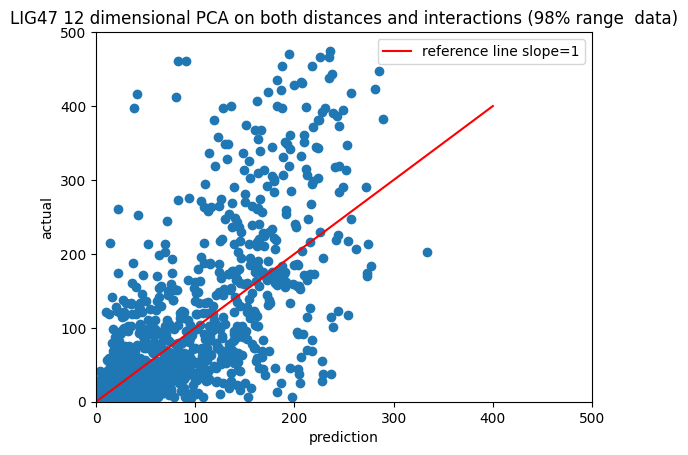

In [23]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 12 dimensional PCA on both distances and interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [17]:
inputs_pca = inputs_pca2

N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_all[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_5_476
avg = avg_5_476

logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

Total events: 32264
With avg distance input data of shape: (32264, 2)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 2)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 2)
max log length: 4.76
min log length: 0.05
mean: [0.34413808 0.03904242]
std deviation: [0.65125155 0.96593141]
standardized avg distance data
(7895, 2)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.55079 | val_0_mse: 0.94313 |  0:00:00s
epoch 1  | loss: 0.473   | val_0_mse: 0.55361 |  0:00:00s
epoch 2  | loss: 0.45081 | val_0_mse: 0.52505 |  0:00:00s
epoch 3  | loss: 0.43174 | val_0_mse: 0.40603 |  0:00:01s
epoch 4  | loss: 0.4205  | val_0_mse: 0.41924 |  0:00:01s
epoch 5  | loss: 0.41959 | val_0_mse: 0.4089  |  0:00:01s
epoch 6  | loss: 0.42418 | val_0_mse: 0.37996 |  0:00:02s
epoch 7  | loss: 0.42452 | val_0_mse: 0.38764 |  0:00:02s
epoch 8  | loss: 0.42165 | val_0_mse: 0.39573 |  0:00:02s
epoch 9  | loss: 0.4234  | val_0_mse: 0.3857  |  0:00:02s
epoch 10 | loss: 0.41532 | val_0_mse: 0.40637 |  0:00:03s
epoch 11 | loss: 0.42253 | val_0_mse: 0.38158 |  0:00:03s
epoch 12 | loss: 0.4187  | val_0_mse: 0.39015 |  0:00:03s
epoch 13 | loss: 0.42521 | val_0_mse: 0.39773 |  0:00:03s
epoch 14 | loss: 0.40737 | val_0_mse: 0.37818 |  0:00:04s
epoch 15 | loss: 0.41091 | val_0_mse: 0.40044 |  0:00:04s
epoch 16 | loss: 0.42183 | val_0_mse: 0.37995 |  0:00:04s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [18]:
print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[1.7872994  0.6163943  0.27706224 ... 0.0995006  0.13886866 1.2082653 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
47.712685
52.27925531914894


r2: 0.6592269673892325


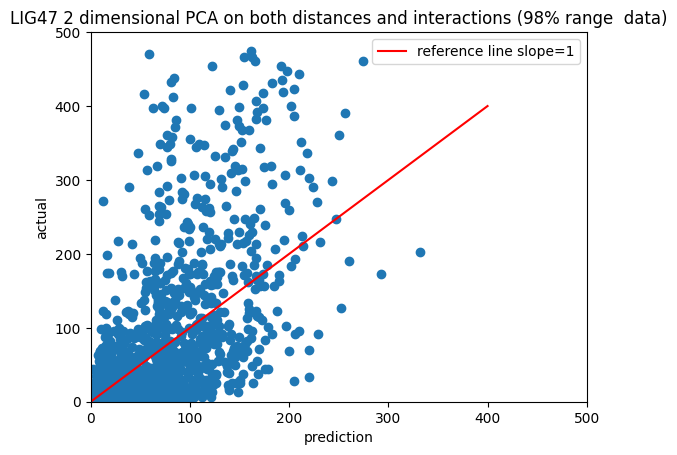

In [20]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 2 dimensional PCA on both distances and interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [25]:
inputs_pca = inputs_pca20

N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_all[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_5_476
avg = avg_5_476

logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

Total events: 32264
With avg distance input data of shape: (32264, 20)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 20)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 20)
max log length: 4.76
min log length: 0.05
mean: [ 0.34413808  0.03904242  0.00209437 -0.28257281  0.01678794  0.10377099
  0.05389265  0.16973935  0.08508245 -0.03675588  0.01203757  0.00473776
 -0.0898944  -0.10181188 -0.25674179  0.08423452 -0.0235325   0.07170944
  0.00879469  0.00354042]
std deviation: [0.65125155 0.96593141 0.96186977 0.80327378 0.82940277 0.83103442
 0.6733462  0.69835136 0.77443035 0.68793041 0.74001074 0.5474237
 0.67035772 0.61069388 0.57029896 0.69382433 0.66990834 0.62958381
 0.68837571 0.69825028]
standardized avg distance data
(7895, 20)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.20714 | val_0_mse: 0.74316 |  0:00:00s
epoch 1  | loss: 0.69128 | val_0_mse: 0.55568 |  0:00:00s
epoch 2  | loss: 0.52004 | val_0_mse: 0.46963 |  0:00:01s
epoch 3  | loss: 0.4308  | val_0_mse: 0.43345 |  0:00:01s
epoch 4  | loss: 0.38403 | val_0_mse: 0.40725 |  0:00:01s
epoch 5  | loss: 0.36095 | val_0_mse: 0.38508 |  0:00:01s
epoch 6  | loss: 0.34473 | val_0_mse: 0.34157 |  0:00:02s
epoch 7  | loss: 0.32249 | val_0_mse: 0.33814 |  0:00:02s
epoch 8  | loss: 0.30981 | val_0_mse: 0.3194  |  0:00:02s
epoch 9  | loss: 0.30523 | val_0_mse: 0.33219 |  0:00:03s
epoch 10 | loss: 0.29197 | val_0_mse: 0.306   |  0:00:03s
epoch 11 | loss: 0.28318 | val_0_mse: 0.31627 |  0:00:04s
epoch 12 | loss: 0.28313 | val_0_mse: 0.29432 |  0:00:04s
epoch 13 | loss: 0.27196 | val_0_mse: 0.32031 |  0:00:04s
epoch 14 | loss: 0.28267 | val_0_mse: 0.29069 |  0:00:05s
epoch 15 | loss: 0.27122 | val_0_mse: 0.29307 |  0:00:05s
epoch 16 | loss: 0.26674 | val_0_mse: 0.28983 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


r2: 0.8135781720726714


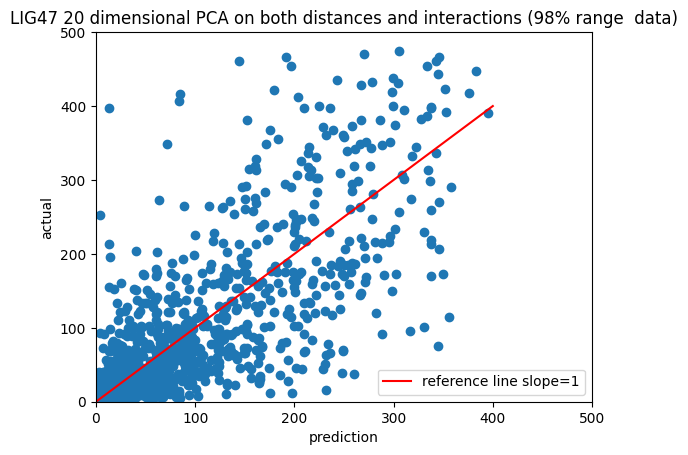

In [26]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 20 dimensional PCA on both distances and interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [28]:
inputs_pca = inputs_pca30

N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_all[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_5_476
avg = avg_5_476

logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

Total events: 32264
With avg distance input data of shape: (32264, 30)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 30)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 30)
max log length: 4.76
min log length: 0.05
mean: [ 0.34413808  0.03904242  0.00209437 -0.28257281  0.01678794  0.10377099
  0.05389265  0.16973935  0.08508245 -0.03675587  0.01203757  0.00473778
 -0.08989455 -0.10181171 -0.25674139  0.08423257 -0.02352682  0.07172052
  0.0087895   0.00369436 -0.04290997 -0.05508679  0.0273968  -0.01593158
  0.00804695 -0.000457   -0.04210662  0.0414571  -0.04123807  0.05590643]
std deviation: [0.65125155 0.96593141 0.96186977 0.80327378 0.82940277 0.83103442
 0.6733462  0.69835135 0.77443035 0.68793041 0.74001074 0.54742373
 0.6703575  0.6106939  0.5702993  0.69382849 0.66990822 0.62956558
 0.68837708 0.69833633 0.70149546 0.74213891 0.71169003 0.71282457
 0.68592921 0.69459698 0.63352022 0.68933772 0.67584

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0654  | val_0_mse: 0.65964 |  0:00:00s
epoch 1  | loss: 0.63056 | val_0_mse: 0.49188 |  0:00:00s
epoch 2  | loss: 0.53963 | val_0_mse: 0.44568 |  0:00:00s
epoch 3  | loss: 0.46953 | val_0_mse: 0.4511  |  0:00:01s
epoch 4  | loss: 0.42389 | val_0_mse: 0.43689 |  0:00:01s
epoch 5  | loss: 0.40895 | val_0_mse: 0.40495 |  0:00:01s
epoch 6  | loss: 0.3827  | val_0_mse: 0.3832  |  0:00:02s
epoch 7  | loss: 0.37838 | val_0_mse: 0.37118 |  0:00:02s
epoch 8  | loss: 0.35469 | val_0_mse: 0.34965 |  0:00:02s
epoch 9  | loss: 0.35441 | val_0_mse: 0.35267 |  0:00:03s
epoch 10 | loss: 0.34899 | val_0_mse: 0.35098 |  0:00:03s
epoch 11 | loss: 0.34993 | val_0_mse: 0.34396 |  0:00:03s
epoch 12 | loss: 0.33526 | val_0_mse: 0.34418 |  0:00:04s
epoch 13 | loss: 0.33823 | val_0_mse: 0.3398  |  0:00:04s
epoch 14 | loss: 0.33801 | val_0_mse: 0.34669 |  0:00:05s
epoch 15 | loss: 0.33483 | val_0_mse: 0.35535 |  0:00:05s
epoch 16 | loss: 0.33564 | val_0_mse: 0.36748 |  0:00:06s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[2.722635   0.1347931  0.03809208 ... 0.206937   0.35175925 1.8830539 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
50.405106
52.27925531914894


r2: 0.8261224208102484


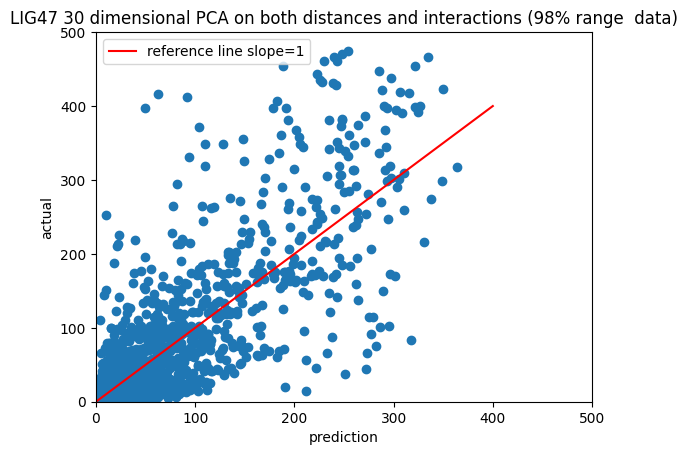

In [29]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 30 dimensional PCA on both distances and interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [30]:
pca1 = PCA(n_components=20, whiten=True)

pca1.fit(combined)
hbond_pca = pca1.transform(combined)

pca2 = PCA(n_components=5, whiten=True)

pca2.fit(dcharges)
charges_pca = pca2.transform(dcharges)

pca3 = PCA(n_components=20, whiten=True)

pca3.fit(hydrocombined)
hydro_pca = pca3.transform(hydrocombined)

all_input = np.concatenate([dmat, hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)

In [31]:
pca_all30 = PCA(n_components=30, whiten=True)

pca_all30.fit(all_input)
inputs_pca30 = pca_all30.transform(all_input)

In [32]:
pca_all50 = PCA(n_components=50, whiten=True)

pca_all50.fit(all_input)
inputs_pca50 = pca_all50.transform(all_input)

In [33]:
inputs_pca = inputs_pca30

N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_all[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_5_476
avg = avg_5_476

logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

Total events: 32264
With avg distance input data of shape: (32264, 30)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 30)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 30)
max log length: 4.76
min log length: 0.05
mean: [ 0.3458244   0.04088478 -0.01730018  0.09398859  0.06509874 -0.18929207
 -0.07881864  0.08571134 -0.02865069  0.13205256  0.04491635 -0.03121235
  0.01036033  0.05373099 -0.03419123  0.08852407  0.03904974  0.14794725
  0.01344388  0.0375595   0.00665679 -0.02926884  0.08960848 -0.03113656
  0.04747797  0.11147842  0.04279388  0.02921781  0.07505553  0.10638629]
std deviation: [0.65275673 0.95937593 0.94593322 0.86678593 0.83915665 0.71493912
 0.66969785 0.7528767  0.66066012 0.79644175 0.77002397 0.77184733
 0.78555444 0.80113586 0.77363304 0.76748081 0.7467326  0.68687789
 0.68047963 0.63990489 0.62873733 0.67840193 0.74140428 0.75204837
 0.67371659 0.79548511 0.67526328 0.67811337 0.65439

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07555 | val_0_mse: 0.69988 |  0:00:00s
epoch 1  | loss: 0.68824 | val_0_mse: 0.54486 |  0:00:00s
epoch 2  | loss: 0.57285 | val_0_mse: 0.50216 |  0:00:01s
epoch 3  | loss: 0.49927 | val_0_mse: 0.4417  |  0:00:01s
epoch 4  | loss: 0.4558  | val_0_mse: 0.41532 |  0:00:02s
epoch 5  | loss: 0.42812 | val_0_mse: 0.36993 |  0:00:02s
epoch 6  | loss: 0.40885 | val_0_mse: 0.36382 |  0:00:03s
epoch 7  | loss: 0.38924 | val_0_mse: 0.35987 |  0:00:03s
epoch 8  | loss: 0.37317 | val_0_mse: 0.36172 |  0:00:03s
epoch 9  | loss: 0.37046 | val_0_mse: 0.3665  |  0:00:04s
epoch 10 | loss: 0.36594 | val_0_mse: 0.35365 |  0:00:04s
epoch 11 | loss: 0.36077 | val_0_mse: 0.36596 |  0:00:05s
epoch 12 | loss: 0.33924 | val_0_mse: 0.35808 |  0:00:05s
epoch 13 | loss: 0.3374  | val_0_mse: 0.35428 |  0:00:05s
epoch 14 | loss: 0.3281  | val_0_mse: 0.34823 |  0:00:06s
epoch 15 | loss: 0.32314 | val_0_mse: 0.34822 |  0:00:06s
epoch 16 | loss: 0.31206 | val_0_mse: 0.32909 |  0:00:06s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1.0979097  0.19802822 0.25748688 ... 0.16094027 1.1269892  2.3849735 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
53.849262
52.27925531914894


r2: 0.8084666191905089


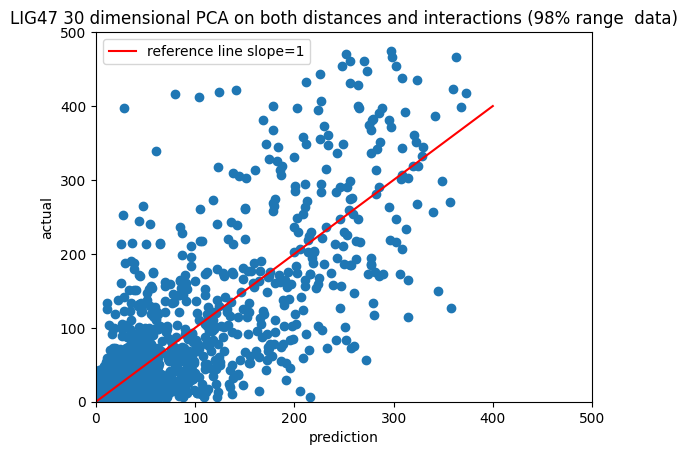

In [34]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 30 dimensional PCA on both distances and interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [35]:
inputs_pca = inputs_pca50

N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_all[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

mapping = mapping_5_476
avg = avg_5_476

logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

Total events: 32264
With avg distance input data of shape: (32264, 50)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 50)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 50)
max log length: 4.76
min log length: 0.05
mean: [ 0.3458244   0.04088478 -0.01730018  0.09398859  0.06509874 -0.18929207
 -0.07881864  0.08571134 -0.02865069  0.13205256  0.04491635 -0.03121235
  0.01036033  0.05373099 -0.03419123  0.08852407  0.03904974  0.14794725
  0.01344388  0.0375595   0.00665681 -0.02926883  0.08960849 -0.03113658
  0.0474778   0.11147947  0.042797    0.02921855  0.0752242   0.10662715
 -0.02887959  0.00420031  0.10750646 -0.1121382  -0.13303049 -0.20256143
 -0.02051632  0.14696881 -0.00127538  0.03003653  0.006573    0.00373669
  0.06698949  0.01355706  0.02588195 -0.02116261 -0.03495537  0.03597005
 -0.01041448  0.00327285]
std deviation: [0.65275673 0.95937593 0.94593322 0.86678593 0.83915665 0.71493912
 0.669697

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.20659 | val_0_mse: 0.79904 |  0:00:00s
epoch 1  | loss: 1.07748 | val_0_mse: 0.73624 |  0:00:00s
epoch 2  | loss: 0.85745 | val_0_mse: 0.69696 |  0:00:01s
epoch 3  | loss: 0.74673 | val_0_mse: 0.61961 |  0:00:01s
epoch 4  | loss: 0.67012 | val_0_mse: 0.59911 |  0:00:02s
epoch 5  | loss: 0.63953 | val_0_mse: 0.56466 |  0:00:02s
epoch 6  | loss: 0.60509 | val_0_mse: 0.55177 |  0:00:02s
epoch 7  | loss: 0.59456 | val_0_mse: 0.53447 |  0:00:03s
epoch 8  | loss: 0.57099 | val_0_mse: 0.52884 |  0:00:03s
epoch 9  | loss: 0.5735  | val_0_mse: 0.52438 |  0:00:03s
epoch 10 | loss: 0.56137 | val_0_mse: 0.53359 |  0:00:04s
epoch 11 | loss: 0.54655 | val_0_mse: 0.51167 |  0:00:04s
epoch 12 | loss: 0.52746 | val_0_mse: 0.49775 |  0:00:04s
epoch 13 | loss: 0.50897 | val_0_mse: 0.475   |  0:00:05s
epoch 14 | loss: 0.47603 | val_0_mse: 0.45557 |  0:00:05s
epoch 15 | loss: 0.44384 | val_0_mse: 0.40702 |  0:00:05s
epoch 16 | loss: 0.41645 | val_0_mse: 0.39553 |  0:00:06s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[1.1114074  0.14296845 0.22677258 ... 0.2066767  0.2439425  0.7411251 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
56.196354
52.27925531914894


r2: 0.8031857202117985


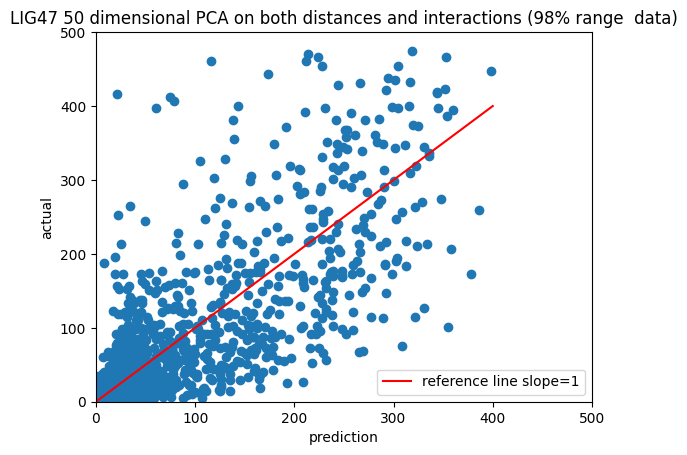

In [36]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 50 dimensional PCA on both distances and interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()